# Classificação de Texto utilizando Convolutional Neural Network
Autor: Lucas Kenji Sudo

E-mail: lucaskenjis@gmail.com

Linkedin : linkedin.com/in/lucas-sudo-701647121/

In [1]:
import pandas as pd
import nltk
import re
import numpy as np
import time

# Imports para NLP
#from nltk import word_tokenize
from bs4 import BeautifulSoup
from nltk import regexp_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

start_time = time.time()

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


#### Remover review duplicadas

In [5]:
df = df[~df.review.duplicated()]

#### Remover colunas null

In [6]:
df=df[~df.review.isnull()]

#### Limpeza

Método para limpeza de texto aplicando:
    - replace para um caractere específico
    - isdigit para verificar se a palavra é um digito e assim, remove-la.
    - limpeza de tag html usando BeautifulSoup
    - regexp_tokenize para transformar textos em tokens, e coletar apenas palavras através do regex [\w]+. Ignorando acentos.
    - .lower() para deixar as palavras minusculas
    - stopwords para remover palavras que não agregam informações

In [7]:
#nltk.download('stopwords')
eng_stpw = set(stopwords.words('english'))

def padronizardados(text):
    # remover caractere especifico
    text = text.replace('\ ','')
    # remover digitos
    text = ''.join([i for i in text if not i.isdigit()])
    # remover tags html
    soup = BeautifulSoup(text, "html.parser")
    #tokenization e lower case
    text = regexp_tokenize(soup.get_text().lower(),"[\w]+")
    #remover stopwords
    temp = []
    for t in text:
        if t not in eng_stpw:
            temp.append(t)
    new_text = (' '.join(temp))
    
    return new_text

##### Texto antes do método

In [8]:
df.review[30]

'Taut and organically gripping, Edward Dmytryk\'s Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger\'s apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who\'s assigned to Ryan\'s outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, h

##### Aplicando método de limpeza aos textos

In [9]:
df.review = df.review.apply(padronizardados)

##### Texto depois do método

In [10]:
df.review[30]

'taut organically gripping edward dmytryk crossfire distinctive suspense thriller unlikely message movie using look devices noir cycle bivouacked washington dc company soldiers cope restlessness hanging bars three end stranger apartment robert ryan drunk belligerent beats host sam levene death happens jewish police detective robert young investigates help robert mitchum assigned ryan outfit suspicion falls second three george cooper vanished ryan slays third buddy steve brodie insure silence young closes abetted superior script john paxton dmytryk draws precise performances three starring bobs ryan naturally prototypical angry white male hilt mitchum underplays characteristic alert nonchalance role however central young may never better gloria grahame gives first fully fledged rendition smart mouthed vulnerable tramp sad sack leeched life paul kelly haunts us small peripheral role makes memorable politically engaged dmytryk perhaps inevitably succumbs sermonizing pretty much confined y

#### Transformar sentiments em 0 e 1 (Label encoder)

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.sentiment= le.fit_transform(df.sentiment)

In [12]:
df = df.rename(columns={"sentiment" : "positive"})

##### Função plot

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# --------------------------------------------------------------

# CNN
   As CNNs podem ser entendidas como um conjunto de várias camadas de convoluções com funções de ativação não lineares. Ela é muito conhecida por sua aplicação em classificação de imagens, mas também está sendo amplamente utilizada para classificação de texto. 
   
   Durante a fase de treinamento, uma CNN aprende automaticamente os valores de seus filtros com base na tarefa que você deseja executar. Caso esteja sendo utilizado para classificação de imagens, ela pode detectar padrões como bordas de figuras, caso esteja sendo utilizado para classificação de texto, pode detectar padrões como expressões ou palavras compostas. 
	As CNNs podem ser construídas com alguns layers:
    - Convolution Layer 
    - Activation Layer
    - Pooling Layer
    - Fully Connected Layer


##### Convolution layer

   É geralmente a primeira e principal camada da CNN, onde aplica-se N filtros (também chamados de kernels) aos dados de entrada. Os filtros são unidades (vetores ou matrizes) que são aplicadas através dos dados, como se fosse uma janela deslizante, extraindo padrões e caracteristicas dos dados.

![](c.gif)

Para aplicações em NLP, filtros n-dimensionais são aplicados ao conjunto de dados. Cada linha da matriz corresponde a um token, geralmente uma palavra ou conjunto de palavras.

![](nlp.png)

##### Activation layer
Conhecido também como Non Linear Activation Layer, é responsável por aprender padrões em dados não lineares. A função mais utilizada é a Relu, onde os dados negativos são transformados em valores igual à ZERO, e dados positivos não alterados.

![](relu.png)

##### Pooling layer
É responsável por reduzir o tamanho espacial das convoluções (obtidas na Convolution layer) através de filtros. Isso é útil para extrair características importantes e para diminuir a complexidade e dimensionalidade do modelo.
Os filtros utilizados tem 2 parâmentros importantes:
    1. Dimension of Spatial Extent: Quantidade de features mapeadas pelo filtro para fazer a redução de dimensionalidade, ou seja, o tamanho do filtro; (No gif abaixo, percebemos o filtro=3x3)
    2. Stride: Quantidade de posições que o filtro avança após uma aplicação. (No gif abaixo, percebemos o Stride = 1) 
    
A técnica mais utilizada é o MaxPooling, que retorna o maior valor dos dados encontrado pelo filtro.

![](pooling.gif)

##### Fully Connected Layer
A camada tem essa nome, pois cada neurônio da camada anterior está conectado ao neurônio da camada posterior. É responsável por aprender as combinações não lineares das features e identificar as categorias da classificação.

##### Split dados
    - Optei por separar os dados em treino, validação e teste

In [14]:
from sklearn.model_selection import train_test_split
  
X_train, X_test, y_train, y_test  = train_test_split(df.review, df.positive, test_size=0.2, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

##### Tokenization

In [110]:
from keras.preprocessing.text import Tokenizer

#Número máximo de palavras do X_train é 100619
tokenizer = Tokenizer(num_words=20000) #10000 #20000 #30000 #OVERFITTING
#tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)
x_val = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [111]:
len(tokenizer.word_index)

92720

* pad_sequence: One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros.

* maxlen = how long the sequences should be

In [112]:
from keras.preprocessing.sequence import pad_sequences

#maxlen = max(len(x) for x in x_train) # longest text in train set
maxlen = 200 #100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)
x_val = pad_sequences(x_val, padding='post', maxlen=maxlen)

print(x_train[0, :])

[   86     1  3253   104    71    56     4   193 11556  3435  6682  3122
  5453   375    86   170   704 11556   885   109   121    19  6346   606
    68   565   120   145     6   218   181   206   307     1  2325  1007
    26 18540    36   544  2903   165     3   141  4063    42    30    60
   390   648   133     1    77  3512    69  3328    71    77   327     6
  2694    16    48    60     1   648   133  2026   461     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [113]:
maxlen

200

* input_dim:tamanho do vocabulary
* output_dim: tamanho do vetor
* input_length: tamanho da entrada

In [114]:
from keras.models import Sequential
from keras import layers

embedding_dim = 200

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(5, 1, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
#model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 200)          18544200  
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 200, 5)            1005      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 100, 5)            0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 501       
Total params: 18,545,706
Trainable params: 18,545,706
Non-trainable params: 0
_________________________________________________________________


In [115]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(x_val, y_val),
                    batch_size=1000)

In [107]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Val Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8032
Val Accuracy:  0.7711
Testing Accuracy:  0.7636


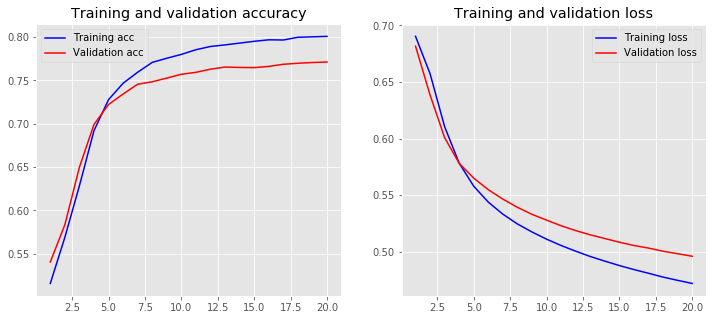

In [108]:
plot_history(history)

In [109]:
from keras.layers import Dense, Activation, Dropout, Flatten, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model, Sequential 
from keras.layers.merge import concatenate
from numpy import array

def define_model(length, vocab_size):
# channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=1, kernel_size=1, activation='relu')(embedding1)
    #drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=1, kernel_size=2, activation='relu')(embedding2)
    #drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=1, kernel_size=1, activation='relu')(embedding3)
    #drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=3)(conv3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    #dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())

    return model

In [30]:
model = define_model(maxlen, vocab_size)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 100)     9272100     input_1[0][0]                    
____________________________________________________________________________________________

In [31]:
history = model.fit([x_train,x_train,x_train], y_train,
                    epochs=10,validation_data=([x_val,x_val,x_val], y_val),
                    batch_size=1000)

Train on 39665 samples, validate on 4959 samples
Epoch 1/10
39665/39665 [==============================] - 24s 598us/step - loss: 0.6889 - acc: 0.5359 - val_loss: 0.6784 - val_acc: 0.5886
Epoch 2/10
39665/39665 [==============================] - 22s 542us/step - loss: 0.6172 - acc: 0.7130 - val_loss: 0.5440 - val_acc: 0.7637
Epoch 3/10
39665/39665 [==============================] - 21s 541us/step - loss: 0.4347 - acc: 0.8201 - val_loss: 0.3919 - val_acc: 0.8298
Epoch 4/10
39665/39665 [==============================] - 20s 506us/step - loss: 0.3195 - acc: 0.8690 - val_loss: 0.3396 - val_acc: 0.8572
Epoch 5/10
39665/39665 [==============================] - 20s 516us/step - loss: 0.2702 - acc: 0.8917 - val_loss: 0.3252 - val_acc: 0.8613
Epoch 6/10
39665/39665 [==============================] - 21s 539us/step - loss: 0.2437 - acc: 0.9034 - val_loss: 0.3233 - val_acc: 0.8617
Epoch 7/10
39665/39665 [==============================] - 21s 538us/step - loss: 0.2269 - acc: 0.9113 - val_loss: 0.3

In [32]:
loss, accuracy = model.evaluate([x_train,x_train,x_train], y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate([x_val,x_val,x_val], y_val, verbose=False)
print("Val Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate([x_test,x_test,x_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9311
Val Accuracy:  0.8570
Testing Accuracy:  0.8449


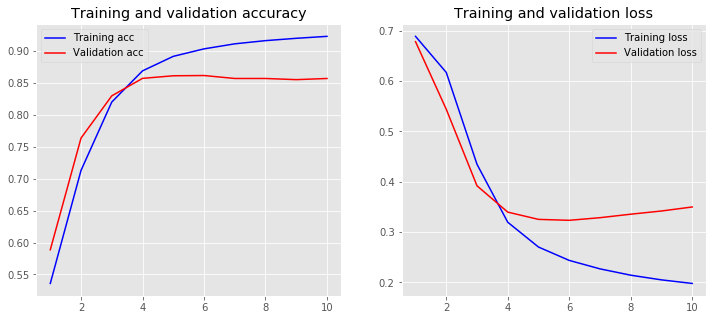

In [33]:
plot_history(history)